Sequential(
  (cnn0): LIAFConvCell(
    (kernel): Conv2d(1, 64, kernel_size=[3, 3], stride=(1, 1))
    (DPLayer): Dropout(p=0, inplace=False)
    (NormLayer): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn1): LIAFConvCell(
    (kernel): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1))
    (DPLayer): Dropout(p=0, inplace=False)
    (NormLayer): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn2): LIAFConvCell(
    (kernel): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1))
    (DPLayer): Dropout(p=0, inplace=False)
    (NormLayer): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): LIAFCell(
    (kernel): Linear(in_features=3200, out_features=10, bias=True)
    (DPLayer): Dropout(p=0, inplace=False)
  )
)
Sequential(
  (cnn0): LIAFConvCell(
    (kernel): Conv2d(1, 64, kernel_size=[3, 3], stride=(1, 1))
    (DPLayer): Dropout(p=0, inplace=False)
    (NormLayer):

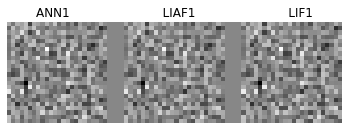

tensor(0.1933, device='cuda:0', grad_fn=<DivBackward0>)


In [46]:
# -*- coding: utf-8 -*-
#python3 example_mnist_scnn.py
from __future__ import print_function
import sys
sys.path.append("..")
from util.util import lr_scheduler
import LIAF
from LIAFnet.LIAFResNet import *

import torch.distributed as dist 
import torch.nn as nn
import argparse, pickle, torch, time, os,sys
from importlib import import_module
from torch.utils.tensorboard import SummaryWriter
from torch.nn.parallel import DistributedDataParallel as DDP
from importlib import import_module
import torchvision
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import matplotlib


save_folder = 'MNIST_LIAF_fromann'
#todo: input your data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
names = 'spiking_model'
data_path = '/data/MNIST/'
workpath = os.path.abspath(os.getcwd())

num_classes = 10
batch_size  = 100

test_set = torchvision.datasets.MNIST(root= data_path, train=False, download=True,  transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []

timeWindows= 10 
learning_rate = 1e-2
num_epochs = 30         # max epoch
modules = import_module('LIAFnet.LIAFCNN')
config = modules.Config()
config.cfgFc =[10]
config.cfgCnn=[(1, 64, 3, 1, 1 ,False),(64, 64, 3, 2, 1 ,True),(64, 128, 3, 2, 1 ,True)]
config.decay = 0.5
config.dropOut= 0
config.timeWindows = timeWindows
config.useBatchNorm= True
config.useLayerNorm= False
config.useThreshFiring = False
config.padding=0
config.dataSize=[28,28]

config.actFun=torch.selu
ANN = modules.LIAFCNN(config).to(device)
ANN.load_state_dict(torch.load(workpath+'/MNIST_pretrain/99modelsaved.t7'))

config.actFun=torch.selu
LIAFnet = modules.LIAFCNN(config).to(device)
LIAFnet.load_state_dict(torch.load(workpath+'/MNIST_LIAF/99LIAFmodelsaved.t7'))

config.actFun=LIAF.LIFactFun.apply 
LIFnet = modules.LIAFCNN(config).to(device)
LIFnet.load_state_dict(torch.load(workpath+'/mnist_scnn_pre_lif_from_liaf/99modelsaved.t7'))

ANNconv = ANN.network[0].kernel
LIFconv = LIFnet.network[0].kernel
LIAFconv = LIAFnet.network[0].kernel

canve = torch.zeros(8*3,3*8*3+8,3)

for _,param in enumerate(ANNconv.named_parameters()):
    if param[0] == 'weight':
        a =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'weight':
        b =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,2] = param[1][i,0,:,:]
        

canve = (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255
plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.title('ANN1                        LIAF1                        LIF1') # 图像题目
plt.show()

print(torch.sum(abs(c-a))/64)

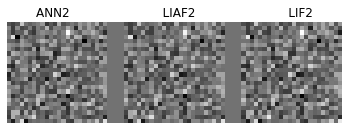

tensor(0.1277, device='cuda:0', grad_fn=<DivBackward0>)


In [47]:

ANNconv = ANN.network[1].kernel
LIFconv = LIFnet.network[1].kernel
LIAFconv = LIAFnet.network[1].kernel

canve = torch.zeros(8*3,3*8*3+8,3)

for _,param in enumerate(ANNconv.named_parameters()):
    if param[0] == 'weight':
        a =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,2] = param[1][i,0,:,:]
        

canve = (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255
plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.title('ANN2                        LIAF2                        LIF2') # 图像题目
plt.show()    
print(torch.sum(abs(c-a))/(64*64))

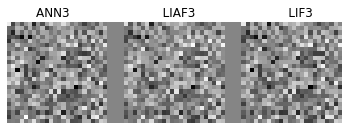

tensor(0.1084, device='cuda:0', grad_fn=<DivBackward0>)


In [48]:

ANNconv = ANN.network[2].kernel
LIFconv = LIFnet.network[2].kernel
LIAFconv = LIAFnet.network[2].kernel

canve = torch.zeros(8*3,3*8*3+8,3)

for _,param in enumerate(ANNconv.named_parameters()):
    if param[0] == 'weight':
        a =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,i%8*3:(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,28+i%8*3:28+(i%8+1)*3,2] = param[1][i,0,:,:]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(64):
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,0] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,1] = param[1][i,0,:,:]
            canve[i//8*3:(i//8+1)*3,56+i%8*3:56+(i%8+1)*3,2] = param[1][i,0,:,:]
        

canve = (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255
plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.title('ANN3                        LIAF3                        LIF3') # 图像题目
plt.show()
print(torch.sum(abs(c-a))/(64*128))

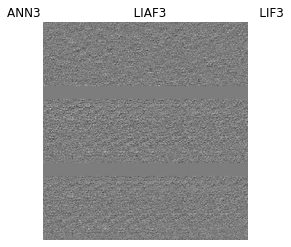

tensor(0.1222, device='cuda:0', grad_fn=<DivBackward0>)


In [54]:
ANNconv = ANN.network[3].kernel
LIFconv = LIFnet.network[3].kernel
LIAFconv = LIAFnet.network[3].kernel

canve = torch.zeros(3*100+40,320,3)

for _,param in enumerate(ANNconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(10):
            canve[i*10:(i+1)*10,0:320,0] = param[1][:,320*i:320*(i+1)]
            canve[i*10:(i+1)*10,0:320,1] = param[1][:,320*i:320*(i+1)]
            canve[i*10:(i+1)*10,0:320,2] = param[1][:,320*i:320*(i+1)]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(10):
            canve[120+i*10:120+(i+1)*10,0:320,0] = param[1][:,320*i:320*(i+1)]
            canve[120+i*10:120+(i+1)*10,0:320,1] = param[1][:,320*i:320*(i+1)]
            canve[120+i*10:120+(i+1)*10,0:320,2] = param[1][:,320*i:320*(i+1)]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(10):
            canve[240+i*10:240+(i+1)*10,0:320,0] = param[1][:,320*i:320*(i+1)]
            canve[240+i*10:240+(i+1)*10,0:320,1] = param[1][:,320*i:320*(i+1)]
            canve[240+i*10:240+(i+1)*10,0:320,2] = param[1][:,320*i:320*(i+1)]
        

canve = (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255
plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.title('ANN3                        LIAF3                        LIF3') # 图像题目
plt.show()
print(torch.sum(abs(c-a))/(64*128))

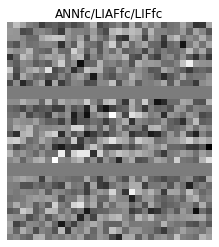

tensor(0.1222, device='cuda:0', grad_fn=<DivBackward0>)


In [57]:
ANNconv = ANN.network[3].kernel
LIFconv = LIFnet.network[3].kernel
LIAFconv = LIAFnet.network[3].kernel

canve = torch.zeros(3*10+4,32,3)

for _,param in enumerate(ANNconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(1):
            canve[i*10:(i+1)*10,0:32,0] = param[1][:,32*i:32*(i+1)]
            canve[i*10:(i+1)*10,0:32,1] = param[1][:,32*i:32*(i+1)]
            canve[i*10:(i+1)*10,0:32,2] = param[1][:,32*i:32*(i+1)]
        
for _,param in enumerate(LIFconv.named_parameters()):
    if param[0] == 'weight':
        for i in range(1):
            canve[12+i*10:12+(i+1)*10,0:32,0] = param[1][:,32*i:32*(i+1)]
            canve[12+i*10:12+(i+1)*10,0:32,1] = param[1][:,32*i:32*(i+1)]
            canve[12+i*10:12+(i+1)*10,0:32,2] = param[1][:,32*i:32*(i+1)]
        
for _,param in enumerate(LIAFconv.named_parameters()):
    if param[0] == 'weight':
        c =  param[1]
        for i in range(1):
            canve[24+i*10:24+(i+1)*10,0:32,0] = param[1][:,32*i:32*(i+1)]
            canve[24+i*10:24+(i+1)*10,0:32,1] = param[1][:,32*i:32*(i+1)]
            canve[24+i*10:24+(i+1)*10,0:32,2] = param[1][:,32*i:32*(i+1)]
        

canve = (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255
plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.title('ANNfc/LIAFfc/LIFfc') # 图像题目
plt.show()
print(torch.sum(abs(c-a))/(64*128))